In [441]:
import pickle, os, time, csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from correlation import plot_qq_for_all_stations
from tabulate import tabulate

from analysis_seasonal import *
from predictions_utils import naive_bias_correction, calculate_variance_per_station
from utils import sample_apply, cdf_apply # QS, BS,

from metrics import ROC, AUC, CRPS_apply, QS, BS, logprob
import CRPS.CRPS as pscore
import NORRIS

import scipy
from sklearn.calibration import calibration_curve
# from torch.distributions import Gamma, Gumbel, HalfNormal, LogNormal

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [442]:
sys.path.append('CONFIG_files/')

## Import model predictions

In [524]:
# import CONFIG_ICIMOD_06May2023 as CONFIG
# import CONFIG_WAPDA_BGMM as CONFIG
# import CONFIG_SUSHIWAT_BGMM as CONFIG
# import CONFIG_COMBINED_BGMM as CONFIG

# import CONFIG_ICIMOD_BGMM_BY_Z as CONFIG
# import CONFIG_SUSHIWAT_BGMM_BY_Z as CONFIG
# import CONFIG_WAPDA_BGMM_BY_Z as CONFIG

# import CONFIG_COMBINED_BGMM_BY_REGION as CONFIG

# import CONFIG_ICIMOD_BGMM_RNN as CONFIG
# import CONFIG_WAPDA_BGMM_RNN as CONFIG
# import CONFIG_COMBINED_BGMM_RNN as CONFIG

# import CONFIG_SUSHIWAT_BGMM_RANDOM_NOISE as CONFIG

# import CONFIG_ICIMOD_BGMM_23_JUNE_2023 as CONFIG
import CONFIG_WAPDA_BGMM_23_JUNE_2023 as CONFIG
# import CONFIG_SUSHIWAT_BGMM_23_JUNE_2023 as CONFIG

# import CONFIG_COMBINED_BGMM_21_AUG_2023_EXP_3 as CONFIG

# import CONFIG_COMBINED_BGMM_21_AUG_2023_EXP_2 as CONFIG

# import CONFIG_WAPDA_BGMM_21_AUG_2023_EXP_4 as CONFIG
# import CONFIG_ICIMOD_BGMM_21_AUG_2023_EXP_4 as CONFIG
# import CONFIG_SUSHIWAT_BGMM_21_AUG_2023_EXP_4 as CONFIG


# RNN_[10] RUNS
# =============
# import CONFIG_ICIMOD_BGMM_09_OCT_2023_EXP_1 as CONFIG
# import CONFIG_WAPDA_BGMM_09_OCT_2023_EXP_1 as CONFIG
# import CONFIG_SUSHIWAT_BGMM_09_OCT_2023_EXP_1 as CONFIG


# WITH IMPORTANCE ANALYSIS
# ================
# import CONFIG_ICIMOD_BGMM_07_NOV_2023_EXP_1 as CONFIG
# import CONFIG_COMBINED_BGMM_09_NOV_2023_EXP_2 as CONFIG


# WITH ALL PROB DISTS
# =============
# import CONFIG_COMBINED_ALLMODELS_19_NOV_2023_EXP_2 as CONFIG
# import CONFIG_ICIMOD_DENSITYDISTS_19_NOV_2023_EXP_1 as CONFIG
# import CONFIG_COMBINED_ALLMODELS_1_DEC_2023_EXP_2 as CONFIG
# import CONFIG_ICIMOD_RECURRENT_2_DEC_2023_EXP_1 as CONFIG

In [525]:
# import CONFIG_ICIMOD_BGMM_09_OCT_2023_EXP_1 as CONFIG_RNN

In [526]:
run_prefix = CONFIG.RUN_NAME

print(run_prefix)

with open(f'/data/hpcdata/users/marron31/_experiments/{run_prefix}/predictions.pkl', 'rb') as handle:
    predictions = pickle.load(handle)

WAPDA_BGMM_23_JUNE_2023


In [527]:
def combine_run_predictions(list_of_configs):
    for idx, C in enumerate(list_of_configs):
        run_prefix = C.RUN_NAME
        print(run_prefix)
        with open(f'/data/hpcdata/users/marron31/_experiments/{run_prefix}/predictions.pkl', 'rb') as handle:
            predictions = pickle.load(handle)
        
        if idx==0:
            uber_predictions = predictions.copy()
        else:
            for k,v in predictions.items():
                uber_predictions[k] = v

    return uber_predictions

In [528]:
combine = False
if combine:
    predictions = combine_run_predictions([CONFIG, CONFIG_RNN])

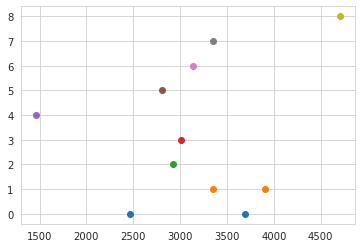

In [529]:
model = list(predictions.keys())[0]

df = predictions[model]['k_all'].groupby('Station').mean()

for i in range(9):
    x = df.loc[df['k_fold']==i,'Z']
    y = df.loc[df['k_fold']==i,'k_fold']
    plt.scatter(x,y,label=i)

# plt.legend()

plt.show()

### Pre-processing

In [530]:
def delete_uncomplete_runs_from_predictions(predictions, CONFIG):
    for k,run in predictions.items():
#         print(k, run.keys())
#         print(len(CONFIG.params['k']))
        if len(run.keys()) < len(CONFIG.params['k']):
            del run
            print(f'deleted run {k}')

In [531]:
delete_uncomplete_runs_from_predictions(predictions, CONFIG)

In [532]:
def create_k_all_predictions(predictions, CONFIG):
    # Create predictions for k_all
    for run in predictions.keys():
        for i in range(len(CONFIG.params['k'])):
            predictions[run][f'k{i}']['k_fold'] = i
            if i == 0:
                predictions[run]['k_all'] = predictions[run][f'k{i}']
            else:
                predictions[run]['k_all'] = pd.concat([predictions[run]['k_all'],predictions[run][f'k{i}']])

In [533]:
create_k_all_predictions(predictions, CONFIG)

### Plot k-fold x-validation

In [534]:
MODEL = list(predictions.keys())[0]

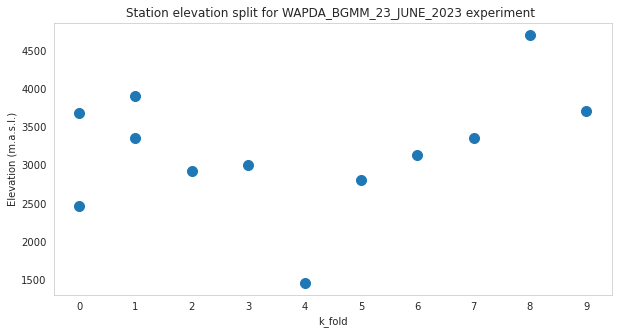

In [535]:
df = predictions[MODEL]['k_all'].groupby('Station').mean().reset_index()

x = df.k_fold
y = df.Z

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.grid()
plt.scatter(x,y, s=100)
plt.xticks([i for i in range(len(set(x)))])
plt.ylabel('Elevation (m.a.s.l.)')
plt.xlabel('k_fold')
plt.title(f'Station elevation split for {CONFIG.RUN_NAME} experiment ')
plt.show()

### Create naive bias corrected hindcast

In [536]:
for k,v in predictions.items():
    predictions[k]['k_all'].loc[:,:] = naive_bias_correction(v['k_all'],ignore_zeros=False)
#     predictions[k]['k_all'].loc[:,:] = calculate_variance_per_station(v['k_all'])
    print(k)

VGLM_[]_bgmm_B=32_D=0_RN=0
MLP_[10]_bgmm_B=32_D=0_RN=0
SimpleRNN_[10]_bgmm_B=32_D=0_RN=0
MLP_[50, 50]_bgmm_B=32_D=0_RN=0
SimpleRNN_[50, 50]_bgmm_B=32_D=0_RN=0


In [537]:
# x = predictions['SimpleRNN_[10]_bgmm_B=32_D=0_RN=0']['k_all'].groupby(['Region']).sum()[['Prec','precip_norris','sample_0']]

In [538]:
# from metrics import *

In [539]:
# absolute_error(x['Prec'],x['sample_0']) - absolute_error(x['Prec'],x['precip_norris'])

### Filter by Region (for experiments 2 and 3)

In [540]:
region = ['EastUIB', 'WestUIB', 'Langtang', 'COMBINED'][0]

print(f"Experiment: {CONFIG.EXPERIMENT}")

if (CONFIG.EXPERIMENT == 2) or (CONFIG.EXPERIMENT == 3):
    print(f'Filter appliedfor region: {region}')
    if region != 'COMBINED':
    
        predictions_region = predictions.copy()
    
        # SELECT REGION PER DATAFRAME
        for k, v in predictions_region.items():
            for k1, v1 in v.items():
                v[k1] = v1[v1['Region']==region]

        # PRINT UNIQUE REGIONS PER DATAFRAME
        # for k, v in predictions_region.items():
        #    for k1, v1 in v.items():
        #        print(k, k1, v1.Region.unique())
else:
    print('No filter applied')

Experiment: 1
No filter applied


### Copy naive bc results to all dataframes

In [541]:
for k,v in predictions.items():
    for n in v['k_all']['k_fold'].unique():
        predictions[k][f'k{n}'] = v['k_all'][v['k_all']['k_fold']==n]

### NEG LOG-LIKELIHOOD

In [542]:
for k,v in predictions.items():
    if 'SimpleRNN' in k:
        continue 
    l = k.split(']_')[1].split('_B')[0]
    p = v['k_all']
    print(k, -logprob(p, dist=l))
    
R = {'WestUIB' : 'WAPDA',
     'EastUIB' : 'SUSHIWAT',
     'Langtang' : 'ICIMOD',
     'COMBINED' : 'COMBINED'}

if CONFIG.REGION == 'COMBINED':
    r = R[region]
else:
    r = CONFIG.REGION

print(r)

p['STD'] = NORRIS.STD[r]
    
print('N19', -logprob(p, dist='gaussian_from_deterministic', det_mu_series='precip_norris', det_sigma_series='STD'))
print('N19-CF', -logprob(p, dist='gaussian_from_deterministic', det_mu_series='naive_bc', det_sigma_series='STD'))

VGLM_[]_bgmm_B=32_D=0_RN=0 tensor(1.2604)
MLP_[10]_bgmm_B=32_D=0_RN=0 tensor(1.2345)
MLP_[50, 50]_bgmm_B=32_D=0_RN=0 tensor(1.2307)
WAPDA
N19 tensor(4.1979, dtype=torch.float64)
N19-CF tensor(2.9805, dtype=torch.float64)


### ROC AUC

In [66]:
import seaborn as sns
sns.set_style('whitegrid')

In [128]:
quantiles = np.concatenate(([0.00001,0.0001,0.001],np.linspace(0,0.99,100),[.999,.9999,.99999,.999999,.9999999,.99999999,.999999999]))

In [129]:
for k,v in predictions.items():
    if ('bernoulli' in k) or ('gmm' in k):
        pass
    else:
        del predictions[k]
        print(k)

KeyboardInterrupt: 

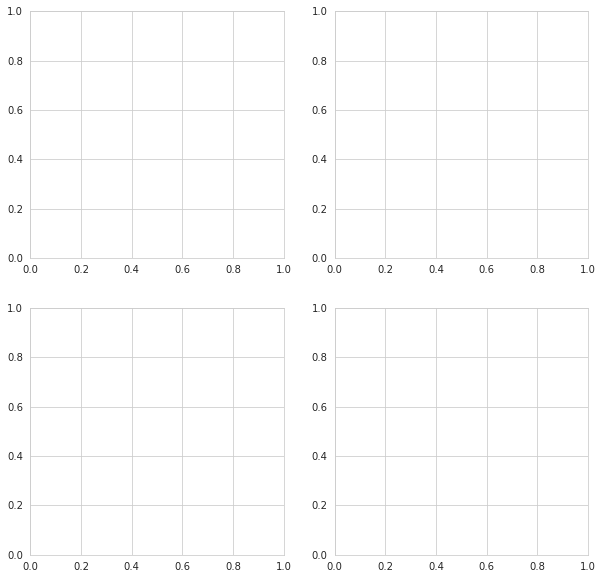

In [130]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

for idx, wet_threshold in enumerate([0.1,1,10,30]):
    
    ax = axes.reshape(-1)[idx]
    
    for idx, (k,v) in enumerate(predictions.items()):
        
#         if idx == 2: continue
#         if idx == 4: continue
        
        TPRs, FPRs = [], []
        
        for q in quantiles:
            TPR, FPR = ROC(v['k_all'],obs='Prec', wet_threshold=wet_threshold, quantile=q, only_wet_days=False)
            TPRs.append(round(TPR,3))
            FPRs.append(round(FPR,3))
            
        auc = AUC(FPRs, TPRs)
        l = f"${k.split('_bgmm')[0].replace('[10]','{S}').replace('[50, 50]','{L}')}$ ({auc:.3f})"
        ax.plot(FPRs, TPRs,'--',label=l)

    ax.plot([0,1],[0,1],'k')
    
    ax.set_xlabel('False alarm rate')
    ax.set_ylabel('Hit rate')
    ax.set_title(f'Threshold = {str(wet_threshold)} mm')

    TPR_sim, FPR_sim = ROC(v['k_all'],obs='Prec',sim='precip_norris',wet_threshold=wet_threshold, quantile=0, only_wet_days=True)
    TPR_bc, FPR_bc = ROC(v['k_all'],obs='Prec',sim='naive_bc',wet_threshold=wet_threshold, quantile=0, only_wet_days=True)
    
    print(f'Wet threshold = {wet_threshold} -- Hit rate: {round(TPR_sim,3)}; False alarm rate: {round(FPR_sim,3)}')

    ax.plot(FPR_sim, TPR_sim, 'ob', label = '$N19$')
    ax.plot(FPR_bc, TPR_bc, 'og', label = '$N19_{CF}$')
    
    ax.legend()

# plt.savefig('figures/auc_roc_exp2_combined_incl_RNN.png')
plt.show()

## CRPS

In [167]:
def CRPS_clim_apply(df, x):
    crps,fcrps,acrps = pscore(x, df['Prec']).compute()
    return crps

In [168]:
def compute_CRPS(predictions, k_fold = 'k_all'): 
    for idx, (k,v) in enumerate(predictions.items()):
            
        s = time.time()
        p = v[k_fold]
        dist = k.split(']_')[1].split('_B')[0]
        print(dist)
        
#         if idx == 0: p['CRPS_clim'] = p.apply(CRPS_clim_apply, axis=1, args=(p['Prec'].to_numpy()))
        
        p['CRPS_mod'] = p.apply(CRPS_apply, dist=dist, axis=1)
        # p['CRPS_bc'] = p.apply(CRPS_apply, axis=1, args=('gaussian','naive_bc'))
        
        e = time.time() - s
        
        print(f'Completed model for {k} in {e:.2f}')

In [169]:
k_fold = 'k_all' #'k_all' # e.g., 'k_all', 'k0', 'k1'

In [170]:
compute_CRPS(predictions, k_fold=k_fold)

bgmm
Completed model for VGLM_[]_bgmm_B=32_D=0_RN=0 in 98.04
bgmm
Completed model for MLP_[10]_bgmm_B=32_D=0_RN=0 in 97.22
bgmm
Completed model for MLP_[50, 50]_bgmm_B=32_D=0_RN=0 in 96.60


In [172]:
for k,v in predictions.items():
    p = v[k_fold]

    p['MAE_sim'] = abs(p['precip_norris'] - p['Prec'])
    p['MAE_bc'] = abs(p['naive_bc'] - p['Prec'])
    
    g = p.groupby('Station').mean()[['CRPS_mod', 'MAE_sim', 'MAE_bc']]
    
#     print("Station Average ==== ",
#           k, 
#           'CRPS MOD -- ', f'{g["CRPS_mod"].mean():.2f}', ' | '
#           'MAE SIM --', f'{g["MAE_sim"].mean():.2f}', ' | '
#           'MAE BC --', f'{g["MAE_bc"].mean():.2f}',
#          )

    print("Total Average ==== ", k, 'CRPS MOD --', f"{v[k_fold]['CRPS_mod'].mean():.3f}")

print('--------------------')    
print('-- MAE_sim --', f"{v[k_fold]['MAE_sim'].mean():.3f}") 
print('-- MAE_bc --', f"{v[k_fold]['MAE_bc'].mean():.3f}") 
    
# print('CRPS BC --', f"{v[k_fold]['CRPS_bc'].mean():.3f}")

Total Average ====  VGLM_[]_bgmm_B=32_D=0_RN=0 CRPS MOD -- 2.524
Total Average ====  MLP_[10]_bgmm_B=32_D=0_RN=0 CRPS MOD -- 2.468
Total Average ====  MLP_[50, 50]_bgmm_B=32_D=0_RN=0 CRPS MOD -- 2.457
--------------------
-- MAE_sim -- 4.308
-- MAE_bc -- 4.621


In [139]:
p['CRPS_sim'] = p.apply(CRPS_apply, axis=1, dist='gaussian_from_deterministic', mean='precip_norris', stdev=NORRIS.STD[R[region]])
p['CRPS_naive'] = p.apply(CRPS_apply, axis=1, dist='gaussian_from_deterministic', mean='naive_bc', stdev=NORRIS.STD[R[region]])

/tmp/ipykernel_5725/2716594923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['CRPS_sim'] = p.apply(CRPS_apply, axis=1, dist='gaussian_from_deterministic', mean='precip_norris', stdev=NORRIS.STD[R[region]])
/tmp/ipykernel_5725/2716594923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['CRPS_naive'] = p.apply(CRPS_apply, axis=1, dist='gaussian_from_deterministic', mean='naive_bc', stdev=NORRIS.STD[R[region]])


In [140]:
p.groupby('Station').mean()[['CRPS_sim','CRPS_naive']].mean()

CRPS_sim      4.638431
CRPS_naive    4.540808
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


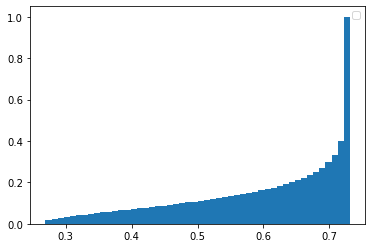

In [87]:
for k,v in predictions.items(): 
    d = v['k_all']
#     print(f"{k}, MAE_SIM = {d.MAE_sim.max():.2f}, MAE_BC = {d.MAE_bc.max():.2f}, CRPS_MOD = {d.CRPS_mod.max():.2f}")
#     print(f"{k}, alpha = {d.alpha.mean():.2f}, beta = {d.beta.mean():.2f}, pi = {d.pi.mean():.2f}")
    plt.hist(d.pi, bins = 50, density=True, cumulative=True) #histtype='step', label = k)
#     plt.hist(d.CRPS_mod, density=True, cumulative=True, histtype='step', )
#     plt.hist(d.MAE_sim, density=True, cumulative=True, histtype='step')
plt.legend()
plt.show()

In [31]:
for k,v in predictions.items():
    print(''.join(k.split('_')[:2]).split('[]')[0].replace('[10]','_{S}').replace('[50, 50]','_{L}'))

MLP_{L}
MLP_{L}
MLP_{L}
MLP_{L}
MLP_{L}


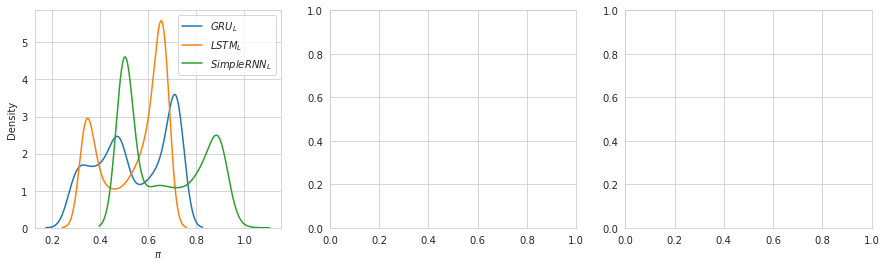

In [31]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
# fig.suptitle(f'{CONFIG.REGION}')
param_labels = [r'$\pi$',r'$\alpha$',r'$\beta$']
for k,v in predictions.items():
    for ax, param, param_label in zip(axes, ['pi','alpha','beta'], param_labels):
        sns.kdeplot(v['k_all'].reset_index()[param], ax=ax, 
                    label='$'+''.join(k.split('_')[:2]).split('[]')[0].replace('[10]','_{S}').replace('[50, 50]','_{L}')+'$')
#         ax.hist(v['k_all'][param], bins = 500, density=True, cumulative=False, histtype='step',label=k, linewidth=2.5)
        ax.set_xlabel(param_label)
        break

ax.legend()
# plt.savefig('figures/params_exp2.png',dpi=300)
plt.show()

In [33]:
for k,v in predictions.items():
    v['k_all'].reset_index(inplace=True)

In [34]:
# for k,v in predictions.items():
#     p = v[k_fold]
    
#     print(k, f"{abs(p['precip_norris'] - p['Prec']).mean():.3f}")
#     print(k, f"{abs(p['naive_bc'] - p['Prec']).mean():.3f}")
#     break
    
# # discrepancy between MAE calculated from the SUSHIWAT BGMM (4.408) experiment
# # and the 'k2' of the BY_REGION COMBINED experiment (4.308)
# # and the SUSHIWAT BGMM BY Z (4.182)

In [82]:
df_b = predictions['VGLM_[]_bgmm_B=32_D=0_RN=0']['k_all'].groupby(['Region','Station']).mean()[['Prec','precip_norris','naive_bc','Z','rain_norris','X','Y']].reset_index()

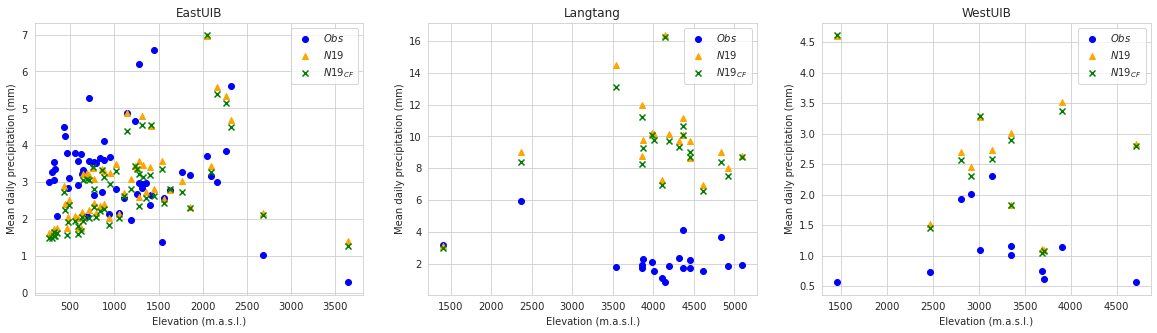

In [96]:
regions = df_b.Region.unique()

fig, axes = plt.subplots(1,3,figsize=(20,5))

for ax, r in zip(axes, regions):
    df_a = df_b[df_b['Region']==r]

    x = df_a['Z'].values
    y = df_a['Prec'].values
    y2 = df_a['precip_norris'].values
#     y3 = df_a['rain_norris'].values
    y3 = df_a['naive_bc'].values
    
    xp = np.linspace(min(x),max(x),100)
    z = np.polyfit(x, y, 2)
    z2 = np.polyfit(x, y2, 2)
    z3 = np.polyfit(x, y3, 2)

    p = np.poly1d(z)
    p2 = np.poly1d(z2)
    p3 = np.poly1d(z3)
    
    ax.scatter(x,y,color='blue', marker = 'o', label = '$Obs$')
    ax.scatter(x,y2,color='orange', marker = '^', label = '$N19$')
    
#     for i in range(len(x)):
#         plt.plot([x[i],x[i]*1,x[i]],[y[i],(y[i]+y2[i])/2,y2[i]],color='grey',linewidth=0.5)

    ax.scatter(x,y3,color='green', marker='x',label = '$N19_{CF}$')
    
#     plt.plot(xp,p(xp),'b--')
#     plt.plot(xp,p2(xp),'g--')
#     plt.plot(xp,p3(xp),'--', color='orange')
    
    ax.set_ylabel('Mean daily precipitation (mm)')
    ax.set_xlabel('Elevation (m.a.s.l.)')
#     plt.grid()
    ax.legend()
    ax.set_title(r)

plt.show()

## Reliability diagrams

In [62]:
MODEL = list(predictions.keys())[0]
MODEL

'VGLM_[]_bgmm_B=32_D=0_RN=0'

In [76]:
threshold = 50

simulated = 'precip_norris'
observed = 'Prec'

#y_pred = (predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'][simulated]>threshold).astype('int')

if threshold == 0:
    y_pred = 1 - predictions[MODEL]['k_all']['pi']
else:
    y_pred = 1 - predictions[MODEL]['k_all'].apply(cdf_apply, axis=1, args=('bgmm','10000',threshold))

y_true = (predictions[MODEL]['k_all'][observed]>threshold).astype('int')

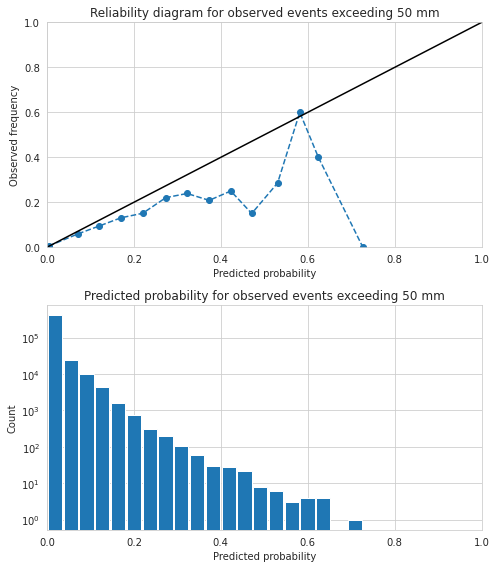

In [77]:
num_bins = 20

prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=num_bins, strategy='uniform')

# print(prob_true)
# print(prob_pred)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,8))

ax1.plot(prob_pred, prob_true, 'o--')
ax1.plot([0,1],[0,1],'k')

ax1.set_xlabel('Predicted probability')
ax1.set_ylabel('Observed frequency')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
# ax1.grid()

ax2.hist(y_pred, bins=num_bins, rwidth=0.9)
ax2.set_yscale('log')
ax2.set_xlim(0,1)
ax2.set_ylabel('Count')
ax2.set_xlabel('Predicted probability')
ax1.set_title(f'Reliability diagram for observed events exceeding {threshold} mm')
ax2.set_title(f'Predicted probability for observed events exceeding {threshold} mm')
plt.tight_layout()
plt.show()

## Brier Score

In [1]:
k_fold = 'k_all'

In [2]:
# region = predictions['SimpleRNN_[10]_bgmm_B=32_D=0_RN=0']['k_all']['Region'].unique()[0]
# print(region)

In [119]:
def brier_score_routine(predictions, simulated='precip_norris', naive_bc='naive_bc', observed='Prec', 
                        threshold=0, print_table = True, export_df = False, export_table = False, yield_df_stations = False,
                        CONFIG = CONFIG):
    
    headers = ['Model', 'Pred', 'Sim', 'Clim', 'Naive', 'BSS_sim', 'BSS_clim', 'BSS_naive']
    table = []
    df_stations = pd.DataFrame()
    
    print(f'Threshold: {threshold:.0f} mm')
#     print(f"{'Model' :<40} {'Pred':<8} {'Sim':<8} {'Clim':<8} {'Rand':<8} {'BSS':<8} {'BSSclim':<8} {'BSSref':<8}")
    
    for idx, run in enumerate(predictions.keys()):

        predictions[run][k_fold].loc[:,'simulated_occurrence'] = (predictions[run][k_fold][simulated]>threshold).astype('int')
        predictions[run][k_fold].loc[:,'observed_occurrence'] = (predictions[run][k_fold][observed]>threshold).astype('int')
        predictions[run][k_fold].loc[:,'naive_occurrence'] = (predictions[run][k_fold][naive_bc]>threshold).astype('int')
        predictions[run][k_fold].loc[:,'climatology_occurrence'] = predictions[run][k_fold]['observed_occurrence'].mean()
        predictions[run][k_fold].loc[:,'climatology_occurrence_station'] = predictions[run][k_fold].groupby('Station')['observed_occurrence'].transform('mean')    
        
        likelihood_fn = run.split(']_')[1].split('_B')[0]
        
        if likelihood_fn == 'b2gmm': continue
        
        if threshold == 0:
            predictions[run][k_fold].loc[:,'modelled_occurrence'] = 1 - predictions[run][k_fold]['pi']
        else:
            predictions[run][k_fold].loc[:,'modelled_occurrence'] = 1 - predictions[run][k_fold].apply(cdf_apply, axis=1, args=(likelihood_fn,'10000',threshold))
            
        predictions[run][k_fold].loc[:,f'BS_naive_{threshold}'] = predictions[run][k_fold].apply(BS, axis=1, args=('naive_occurrence','Prec',threshold))
        predictions[run][k_fold].loc[:,f'BS_sim_{threshold}'] = predictions[run][k_fold].apply(BS, axis=1, args=('simulated_occurrence','Prec',threshold))
        predictions[run][k_fold].loc[:,f'BS_obs_{threshold}'] = predictions[run][k_fold].apply(BS, axis=1, args=('climatology_occurrence','Prec',threshold))
        predictions[run][k_fold].loc[:,f'BS_obs_station_{threshold}'] = predictions[run][k_fold].apply(BS, axis=1, args=('climatology_occurrence_station','Prec',threshold))

        ref_naive = predictions[run][k_fold].loc[:,f'BS_naive_{threshold}'].mean()
        ref_sim = predictions[run][k_fold].loc[:,f'BS_sim_{threshold}'].mean()
        ref_clim = predictions[run][k_fold].loc[:,f'BS_obs_{threshold}'].mean()
        ref_clim_station = predictions[run][k_fold].loc[:,f'BS_obs_station_{threshold}'].mean()
            
        predictions[run][k_fold].loc[:,f'BS_{threshold}'] = predictions[run][k_fold].apply(BS, axis=1, args=('modelled_occurrence','Prec',threshold))
        
        pred = predictions[run][k_fold][f'BS_{threshold}'].mean()
#         print(f"{run :<40} {pred:<8.3f} {ref_sim:<8.3f} {ref_clim:<8.3f} {ref_rand:<8.3f} {1-pred/ref_sim:<8.3f} {1-pred/ref_clim:<8.3f} {1-ref_sim/ref_clim:<8.3f}")
                        
        table.append([run, f'{pred:.3f}', f'{ref_sim:.3f}', f'{ref_clim:.3f}', f'{ref_naive:.3f}', f'{1-pred/ref_sim:.3f}', f'{1-pred/ref_clim:.3f}', f'{1-pred/ref_naive:.3f}'])
        
    if export_df: pd.DataFrame(table,columns=headers).to_csv(f'exports/{CONFIG.RUN_NAME}_threshold={threshold}_{region}.csv')
#     if export_df: pd.DataFrame(table,columns=headers).to_csv(f'exports/{CONFIG.RUN_NAME}_threshold={threshold}_{k_fold}.csv')        
                   
    if print_table: print(tabulate(table, headers, tablefmt='Simple'))

    if export_table:
        
        # add table to existing file, after existing data
        with open(f'notebooks/{CONFIG.RUN_NAME}.csv', 'a') as f:
            f.write(tabulate(table, headers, tablefmt='plain'))
            f.write('\n')
    
    if yield_df_stations:
        
        BS_station = predictions[run][k_fold].groupby('Station').mean()
        BS_station.loc[:,'BSS_clim'] = 1 - BS_station[f'BS_{threshold}'] / BS_station[f'BS_obs_station_{threshold}']
        BS_station.loc[:,'BSS_sim'] = 1 - BS_station[f'BS_{threshold}'] / BS_station[f'BS_sim_{threshold}']
        BS_station.loc[:,'BSS_naive'] = 1 - BS_station[f'BS_{threshold}'] / BS_station[f'BS_naive_{threshold}']
        
        # print(BS_station[[f'BS_{threshold}', f'BS_sim_{threshold}', f'BS_obs_station_{threshold}', 'BSS', 'BSS_clim']])
        BS_station_sel = BS_station[[f'BS_{threshold}', f'BS_sim_{threshold}', f'BS_obs_station_{threshold}', 'BSS', 'BSS_clim']].copy()
        BS_station_sel.to_csv(f'/data/hpcdata/users/marron31/_exports/{run_prefix}_{run}_Q{threshold}.csv')
        BS_station_sel = BS_station_sel.add_prefix(run+'_')
        df_stations = pd.concat([df_stations, BS_station_sel], axis=1)
    
        return df_stations
    
    return None

In [120]:
thresholds = [0,1,10,30,50]

for th in thresholds:
    brier_score_routine(predictions, threshold=th, export_df=False, export_table=False)

Threshold: 0 mm
Model                                               Pred    Sim    Clim    Naive    BSS_sim    BSS_clim    BSS_naive
------------------------------------------------  ------  -----  ------  -------  ---------  ----------  -----------
MLP_[50, 50]_bgmm_B=32_D=0_RN=0                    0.136  0.297   0.179    0.297      0.543       0.243        0.543
MLP_[50, 50]_bernoulli_loggaussian_B=32_D=0_RN=0   0.136  0.297   0.179    0.297      0.543       0.243        0.543
MLP_[50, 50]_bernoulli_gaussian_B=32_D=0_RN=0      0.14   0.297   0.179    0.297      0.527       0.217        0.527
MLP_[50, 50]_bernoulli_gumbel_B=32_D=0_RN=0        0.134  0.297   0.179    0.297      0.547       0.249        0.547
MLP_[50, 50]_bernoulli_halfnormal_B=32_D=0_RN=0    0.141  0.297   0.179    0.297      0.524       0.211        0.524
Threshold: 1 mm
Model                                               Pred    Sim    Clim    Naive    BSS_sim    BSS_clim    BSS_naive
--------------------------------

In [88]:
# print("-------------------- BRIER SCORE AND BRIER SKILL SCORE -------------------")

# BS_0 = brier_score_routine(predictions, threshold=0)
# BS_1 = brier_score_routine(predictions, threshold=1)
# BS_10 = brier_score_routine(predictions, threshold=10)
# BS_30 = brier_score_routine(predictions, threshold=30)
# BS_50 = brier_score_routine(predictions, threshold=50)
# BS_100 = brier_score_routine(predictions, threshold=100)

### Time Series

In [42]:
model = list(predictions.keys())[0]

In [43]:
from utils import sample_apply
import statsmodels.api as sm

In [44]:
for model in list(predictions.keys()):
    df = predictions[model]['k_all']
#     df['uniform'] = np.random.uniform(size=len(df))
#     df['sample'] = df.apply(sample_apply, axis=1)
    
    α = df['alpha'].mean()
    β = df['beta'].mean()
    π = df['pi'].mean()
    σ = np.sqrt(df['alpha']/(df['beta']**2)).mean()
    
    α_σ = df['alpha'].std()
    β_σ = df['beta'].std()
    π_σ = df['pi'].std()
    
    
    print(model)
    print([f'{i:.3f}' for i in sm.tsa.pacf(df['Prec'],nlags=5)])
    print([f'{i:.3f}' for i in sm.tsa.pacf(df['precip_norris'],nlags=5)])
    print([f'{i:.3f}' for i in sm.tsa.pacf(df['naive_bc'],nlags=5)])
    print([f'{i:.3f}' for i in sm.tsa.pacf(df['sample_0'],nlags=5)])
    print(f'π={π:.3f}, α={α:.3f}, β={β:.3f}, σ = {σ:.3f}')
    print(f'π_σ={π_σ:.3f}, α_σ={α_σ:.3f}, β_σ={β_σ:.3f}')
    print(f"Observed dry days: {(1 - sum(df['Prec']>0)/len(df['Prec'])):.3f}")
    print(f"Simulated dry days: {(1 - sum(df['precip_norris']>0)/len(df['precip_norris'])):.3f}")
    print(f"Modelled dry days: {(1 - sum(df['sample_0']>0)/len(df['sample_0'])):.3f}")
    print('\n')

SimpleRNN_[10]_bgmm_B=32_D=0_RN=0
['1.000', '0.442', '0.124', '0.022', '0.025', '0.075']
['1.000', '0.473', '0.161', '0.147', '0.124', '0.088']
['1.000', '0.478', '0.165', '0.149', '0.124', '0.089']
['1.000', '0.199', '0.155', '0.128', '0.117', '0.093']
π=0.553, α=1.343, β=0.735, σ = 2.232
π_σ=0.194, α_σ=0.795, β_σ=0.593
Observed dry days: 0.615
Simulated dry days: 0.398
Modelled dry days: 0.548




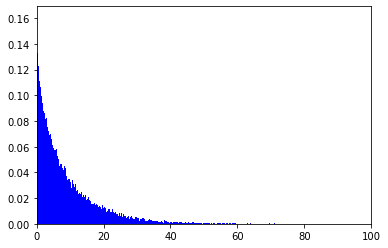

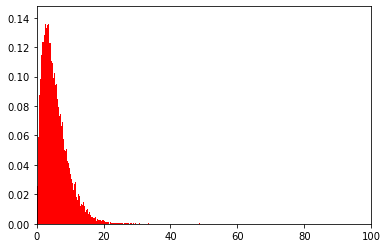

In [45]:
plt.hist(np.random.gamma(shape=0.9, scale=1/0.1, size=100000), bins=1000, color='b', density=True)
plt.xlim(0,100)
plt.show()
plt.hist(np.random.gamma(shape=2.04, scale=1/0.37, size=100000), bins=1000, color='r', density=True)
plt.xlim(0,100)
plt.show()

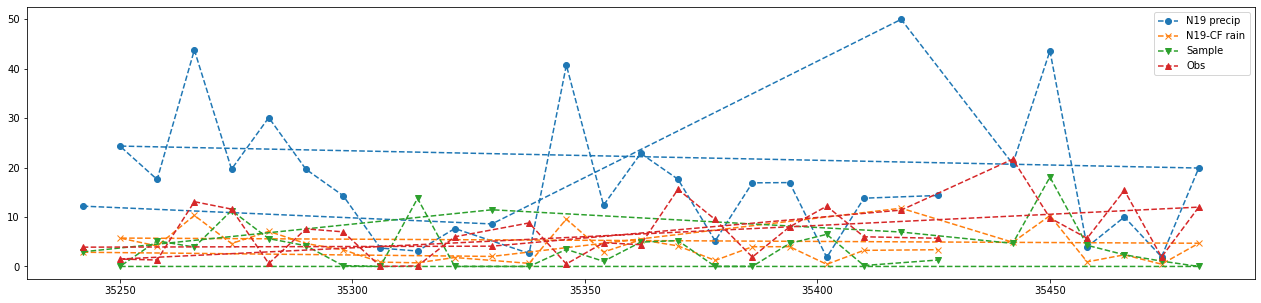

In [79]:
station = df.Station.unique()[np.random.randint(len(df.Station.unique()))]

s = 100
e = 130

df_s = df[df['Station']==station].sort_values(by='Date')
y1 = df_s['precip_norris'][s:e]
y2 = df_s['naive_bc'][s:e]
y3 = df_s['sample_0'][s:e]
y4 = df_s['Prec'][s:e]

plt.figure(figsize=(22,5))

plt.plot(y1, 'o--', label='N19 precip')
plt.plot(y2, 'x--', label='N19-CF rain')
plt.plot(y3, 'v--', label='Sample')
plt.plot(y4, '^--', label='Obs')

plt.legend()
plt.show()

## Quantile Score

In [71]:
def compute_QS(predictions, quantile = 0.5, simulated='naive_bc', observed='Prec'): 
    for k,v in predictions.items():
        
        p = v['k_all']
        p[f'Q_clim_{quantile}'] = p.groupby(['xland_norris'])['Prec'].transform(lambda x: np.quantile(x, quantile))
        p[f'Q_sim_{quantile}'] = p.groupby(['xland_norris'])['precip_norris'].transform(lambda x: np.quantile(x, quantile))
        
        p[f'Q_quantile_{quantile}'] = quantile
        likelihood = k.split('_')[2]
        p[f'Q_mod_{quantile}'] = p.apply(sample_apply, axis=1, args=(likelihood, 1000, f'Q_quantile_{quantile}'))
        
        p[f'QS_mod_{quantile}'] = p.apply(QS, axis=1, args=(f'Q_mod_{quantile}', 'Prec', quantile))
        p[f'QS_sim_{quantile}'] = p.apply(QS, axis=1, args=(f'Q_sim_{quantile}', 'Prec', quantile))
        p[f'QS_clim_{quantile}'] = p.apply(QS, axis=1, args=(f'Q_clim_{quantile}', 'Prec', quantile))
        
        print(f'Completed {k} {quantile}')

In [75]:
%%time

quantiles = [0, 0.50, 0.90]

for quantile in quantiles: 
    compute_QS(predictions, quantile = quantile)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.2 µs


In [96]:
quantiles = [0, 0.50, 0.90]

In [ ]:
headers = ['Model', 'Pred', 'Sim', 'Clim', 
#            'QSS_sim', 'QSS_clim', 'QSS_ref'
          ]
print(" ------------------------- QUANTILE SCORE AND QUANTILE SKILL SCORE -------------------------")
for quantile in quantiles:
    table = []
    print(f'Quantile {quantile}')
    # print(f"{'Model' :<40} {'Pred':<8} {'Sim':<8} {'Clim':<8} {'QSS':<8} {'QSSclim':<8} {'QSSref':<8}")
    for k,v in predictions.items():
    #    pass
    #    print(f"{k : <40} {v['k_all'][f'QS_mod_{quantile}'].mean():<8.3f} {v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f} {v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}  {1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f} {1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f} {1 - v['k_all'][f'QS_sim_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}")
        table.append([f"{k : <40}", f"{v['k_all'][f'QS_mod_{quantile}'].mean():<8.3f}", 
                      f"{v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f}", 
                      f"{v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}", 
#                       f"{1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_sim_{quantile}'].mean():<8.3f}", 
#                       f"{1 - v['k_all'][f'QS_mod_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}", 
#                       f"{1 - v['k_all'][f'QS_sim_{quantile}'].mean()/v['k_all'][f'QS_clim_{quantile}'].mean():<8.3f}"
                     ])
                      
    print(tabulate(table, headers, tablefmt='simple'))
    print('\n')
    # df_table = pd.DataFrame(table,columns=headers)

## Time series

In [177]:
# df = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].copy()
# s = df.Station.unique()[np.random.randint(len(df.Station.unique()))]
# i = 300
# df = df[df.Station == s][i:i+50].copy()

# x0 = df['Date']
# x1 = df['Prec']
# x2 = df['precip_norris']

In [176]:
# plt.figure(figsize=(25,5))
# for i in range(10):
#     x3 = df[f'sample_{i:.0f}']
#     plt.plot(x0, x3, '--', label=f'MLP_{i}', alpha=.5)

# plt.plot(x0, x1, '-og', label='Obs', linewidth=3)
# plt.plot(x0, x2, '-ob', label='WRF', linewidth=2)

# plt.legend()
# plt.title(f"Station: {s}")
# plt.show()

## QQ plots

In [45]:
# predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].describe()
len(predictions['SimpleRNN_[10]_bgmm_B=128_D=0_RN=0']['k_all']['Station'].unique())

12

In [175]:
# df = predictions['SimpleRNN_[10]_bgmm_B=128_D=0_RN=0']['k_all']

In [168]:
# from scipy import stats

In [169]:
# plt.plot(df['pi'], abs(0.1 - df['pi']) / (1 - df['pi']),'x')

In [170]:
# plt.plot(df['pi'], (df['pi'].to_numpy() < q).astype('int') * abs(q - df['pi']) / (1 - df['pi']), 'x')

In [171]:
# plt.plot(np.arange(0.01,1,0.01), np.quantile(df['Prec'], np.arange(0.01,1,0.01)))

In [172]:
# ys = []
# qs = np.linspace(0.01,0.99,20)
# for q in qs:
#     y = (q > df['pi'].to_numpy()).astype('int') * stats.gamma.ppf(q=(q - df['pi'])/(1-df['pi']), a=df['alpha'].to_numpy(), loc=0, scale=1/df['beta'].to_numpy())
#     # x = 1 - df['pi']
#     y = np.nan_to_num(y).mean()
#     print(q, y)
#     ys.append(y)

# plt.plot(qs, ys,'.')

In [173]:
# q = 0.01
# y = (q > df['pi'].to_numpy()).astype('int') * stats.gamma.ppf(q=(q - df['pi'])/(1-df['pi']), a=df['alpha'].to_numpy(), loc=0, scale=1/df['beta'].to_numpy())
# y

In [174]:
# plt.plot(y[:10000],'.')

VGLM_[]_bgmm_B=32_D=0_RN=0


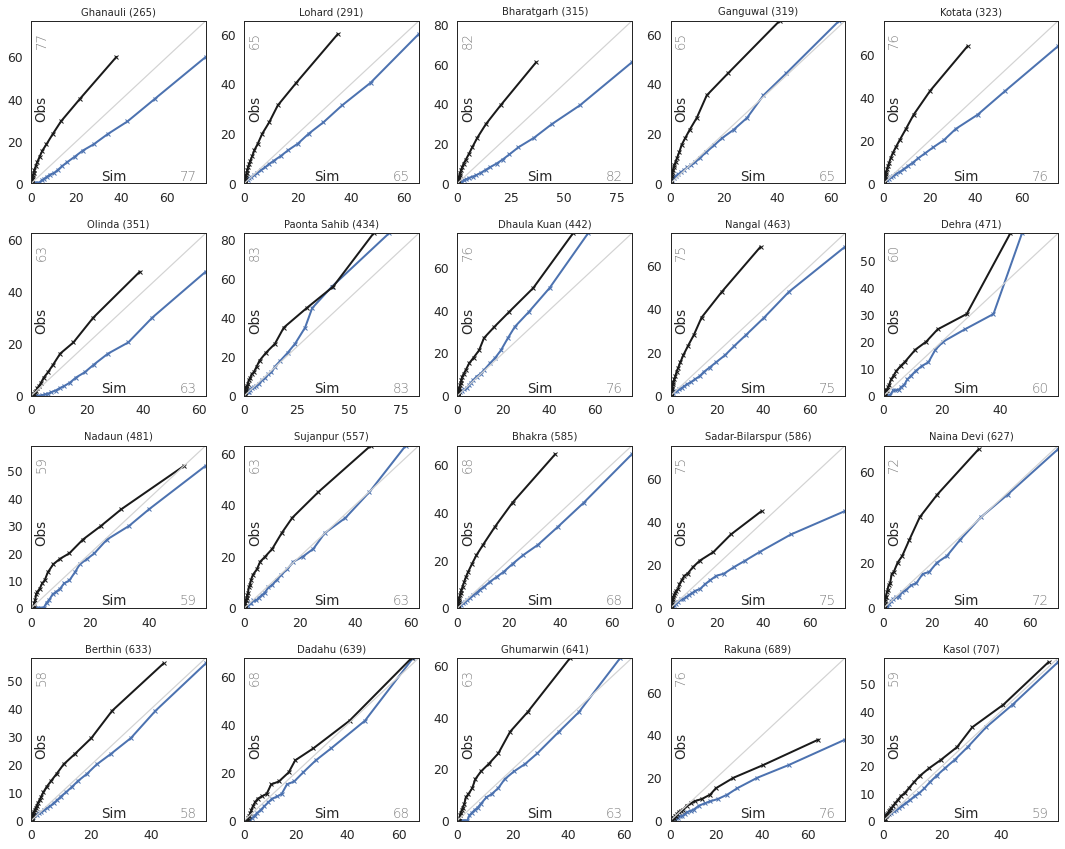

done
MLP_[10]_bgmm_B=32_D=0_RN=0


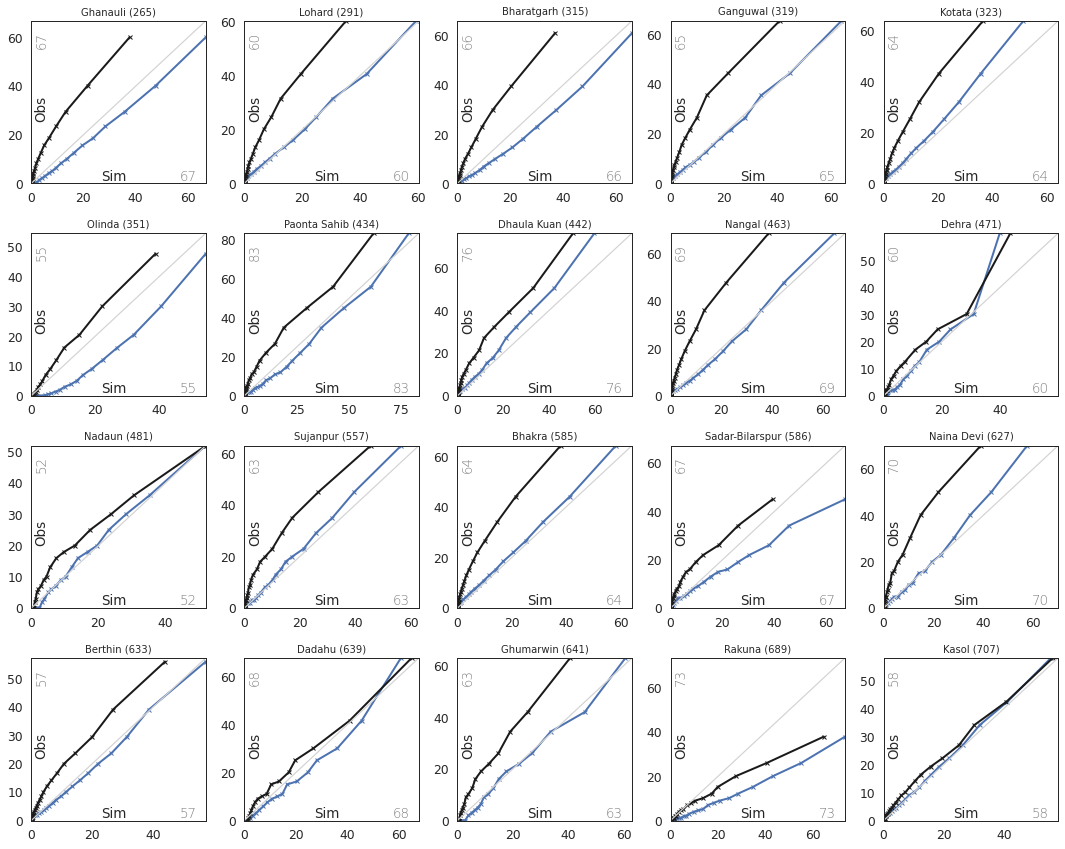

done
SimpleRNN_[10]_bgmm_B=32_D=0_RN=0


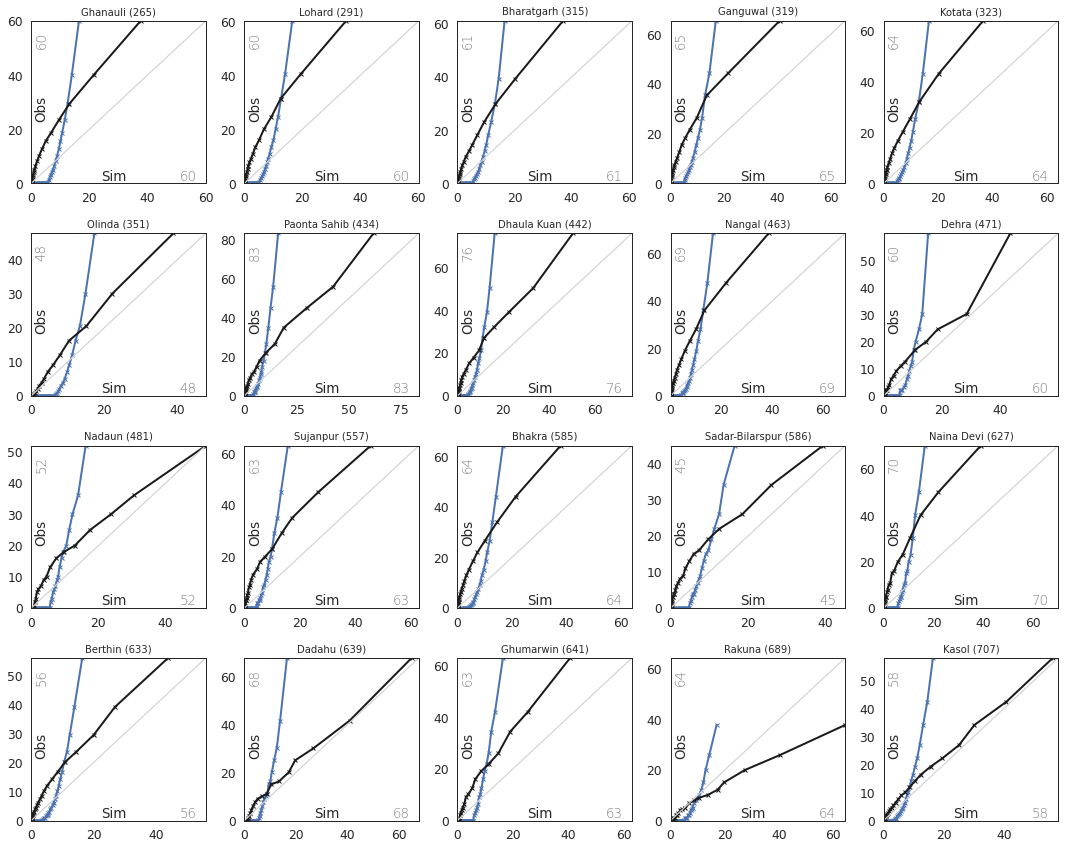

done
MLP_[50, 50]_bgmm_B=32_D=0_RN=0


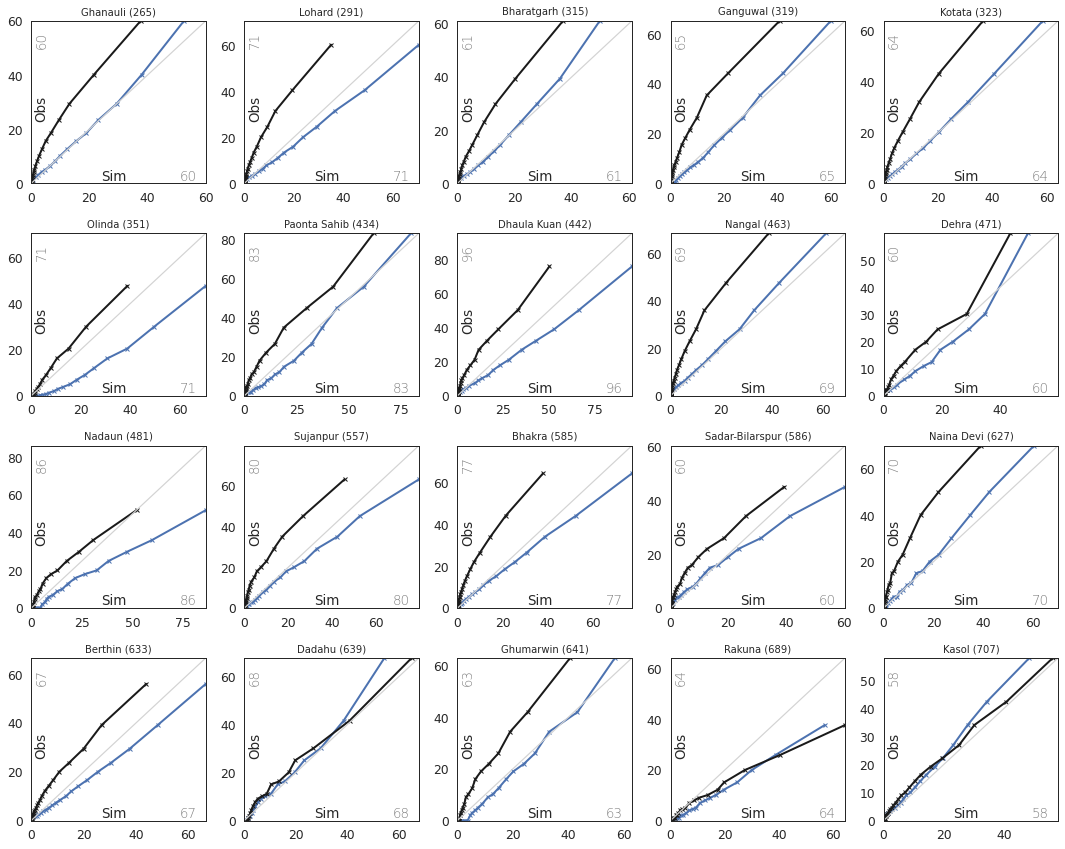

done
SimpleRNN_[50, 50]_bgmm_B=32_D=0_RN=0


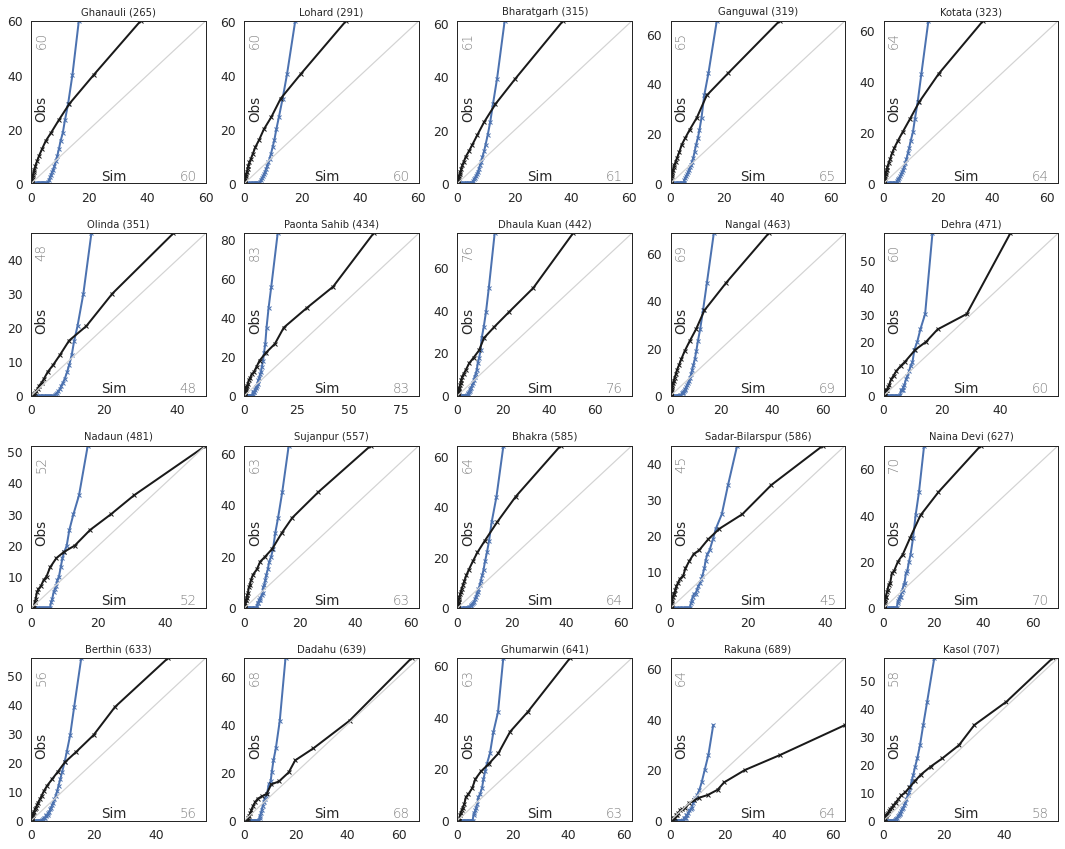

done


In [41]:
models = list(predictions.keys())
for model in models:
    print(model)
    plot_qq_for_all_stations(predictions[model]['k_all'], n_rows=4, n_cols=5, 
                         sim='naive_bc', obs='Prec', mod='sample_0', plot_all_samples=True)

## [OLD] Seasonal analysis 

In [26]:
sample_cols = [f'sample_{i}' for i in range(CONFIG.n_samples)]
add_cols = []
columns = ['Prec','wrf_prcp','wrf_bc_prcp','precip_norris']

In [27]:
for p in predictions.keys(): 
    for k,v in predictions[p].items():
        v['wrf_prcp'] = v['precip_norris'] 
        v['wrf_bc_prcp'] = v['precip_norris'] 

In [28]:
for k,v in predictions.items():
    print(f"{k : <40} {v['k_all'].BS.mean():.3f}")

VGLM_[]_bgmm_B=128_D=0                   0.573
MLP_[10]_bgmm_B=128_D=0                  0.585
SimpleRNN_[10]_bgmm_B=128_D=0            0.422
MLP_[50, 50]_bgmm_B=128_D=0              0.593
SimpleRNN_[50, 50]_bgmm_B=128_D=0        0.421


In [150]:
# table_of_predictions_ks_test(predictions, CONFIG.seasons, columns, sample_cols, add_cols)

In [151]:
# table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'smape', prefix='smape')

In [152]:
# table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'edd', prefix='edd')

In [153]:
# table_of_predictions_for_metric(predictions, CONFIG.seasons, columns, CONFIG.n_samples, sample_cols, add_cols, metric = 'ae', prefix='ae')

In [289]:
predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].Region

84394     WestUIB
84395     WestUIB
84396     WestUIB
84397     WestUIB
84398     WestUIB
           ...   
272607    EastUIB
272608    EastUIB
272609    EastUIB
272610    EastUIB
272611    EastUIB
Name: Region, Length: 456725, dtype: object

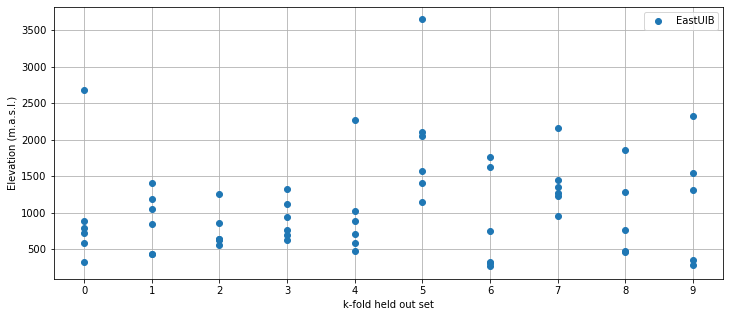

In [44]:
regions = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].Region.unique()
plt.figure(figsize=(12,5))

for r in regions:
    
    df = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].copy()
    
    x = df[df.Region==r].groupby('Station').mean()['k_fold'].to_numpy()
    y = df[df.Region==r].groupby('Station').mean()['Z'].to_numpy()
    
    plt.plot(x,y,'o', markersize=6, label=r)
    
plt.legend()
plt.grid()
plt.xticks(np.arange(10))
plt.ylabel('Elevation (m.a.s.l.)')
plt.xlabel('k-fold held out set')
plt.show()

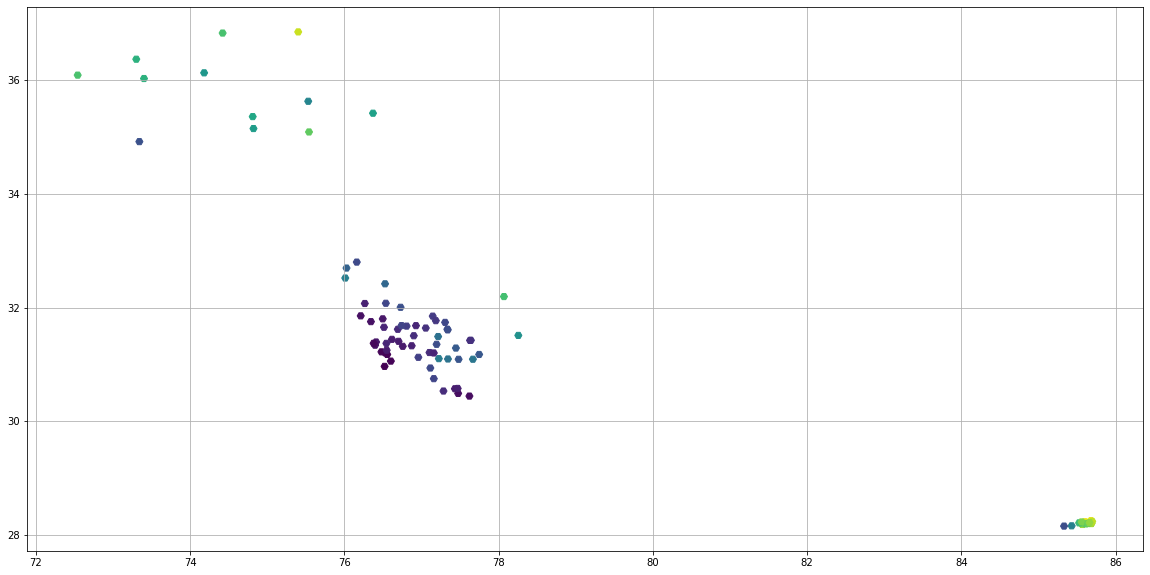

In [112]:
df = predictions['MLP_[10]_bgmm_B=128_D=0']['k_all'].copy()

plt.figure(figsize=(20, 10))

x = df.groupby('Station').agg('first')['X']
y = df.groupby('Station').mean()['Y']
z = df.groupby('Station').mean()['Z']
c = df.groupby('Station').agg('first')['k_fold']

plt.scatter(x,y,c=z,s=50,cmap='viridis', marker='H')
plt.grid()
plt.show()

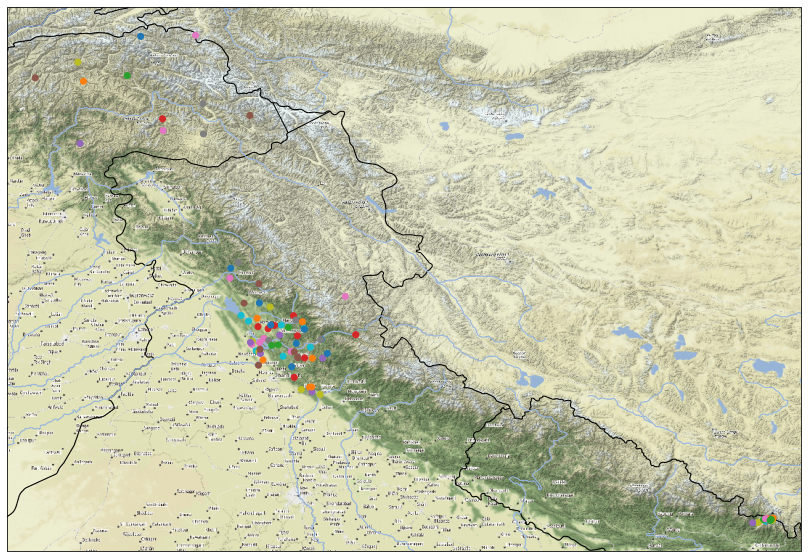

In [122]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
import cartopy.io.img_tiles as cimgt
from cartopy.io import srtm

ϵ= 0.5

# Create a scatter plot with a basemap
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([x.min()-ϵ, x.max()+ϵ, y.min()-ϵ, y.max()+ϵ], crs=ccrs.PlateCarree())

# Create a Stamen Terrain tile source instance
terrain_tiles = cimgt.Stamen(style='terrain')
ax.add_image(terrain_tiles, 8)

# Add the terrain basemap
# ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
# ax.add_feature(cfeature.STATES)

#add_feature scatter plot of the points
ax.scatter(x, y, c=c, marker='o', transform=ccrs.PlateCarree(), cmap='tab10')

# Show the plot
plt.show()
